In [1]:
import scipy as sp
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime



from NN_architectures import *

/Users/Dave/anaconda3/envs/deepnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# some constants

LEARNING_RATE = 0.0001
BETA1 = 0.5
BATCH_SIZE = 32
EPOCHS = 5
SAVE_SAMPLE_PERIOD = 100

#task='TEST'
task='TRAIN'
PATH='DCGAN_test'
SEED = 1

trunc_normal= tf.truncated_normal_initializer(stddev=0.02, seed=SEED)
normal = tf.random_normal_initializer(stddev=0.02, seed=SEED)

In [3]:
global d_sizes, g_sizes

# # Convolutional layers
        
d_sizes = {
         'conv_layers': [(2, 6, 2, False, 1, lrelu, trunc_normal),
                         (64, 6, 2, True, 1, lrelu, trunc_normal)],
         'dense_layers': [(1024, True, 1, lrelu ,normal)],
}
g_sizes = {
         'z': 100,
         'projection': 128,
         'bn_after_project': False,
         'dense_layers': [(1024, True, 1, tf.nn.relu, normal)],
         'conv_layers': [(128, 6, 2, True, 1, tf.nn.relu ,normal),
                         (1, 6, 2, False, 1,  tf.sigmoid, normal)],
}

In [4]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = mnist.train.images

    X_train = X_train.reshape(len(X_train),28,28,1)
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    X_test = X_test.reshape(len(X_test),28,28,1)
    
    tf.reset_default_graph()
    
    
    gan = DCGAN(n_H, n_W, n_C, d_sizes, g_sizes,
                lr_g=LEARNING_RATE, lr_d=LEARNING_RATE, beta1=BETA1,
                batch_size=BATCH_SIZE, epochs=EPOCHS,
                save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
        
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        done = False
        while not done:
            
            
            Z_in = np.random.uniform(-1,1, size=(1, g_sizes['z']))
            
            im = gan.get_sample(Z_in)
            
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.show()
            
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional Network architecture detected
Discriminator_A
Convolution
Input for convolution shape  (?, 28, 28, 1)
(3136, 1024)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 100)
0
Deconvoluted output shape (?, 28, 28, 1)
Discriminator_A
Convolution
Input for convolution shape  (?, 28, 28, 1)
(3136, 1024)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 100)
0
Deconvoluted output shape (?, 28, 28, 1)

 Training...

 ****** 

Training DCGAN with a total of 55000 samples distributed in batches of size 32

The learning rate set for the generator is 0.0001 while for the discriminator is 0.0001, and every 100 epoch a generated sample will be saved to DCGAN_test

 ****** 

Epoch: 0
At iter: 100  -  dt: 0:00:01.713722 - d_acc: 0.2188
Sav

KeyboardInterrupt: 

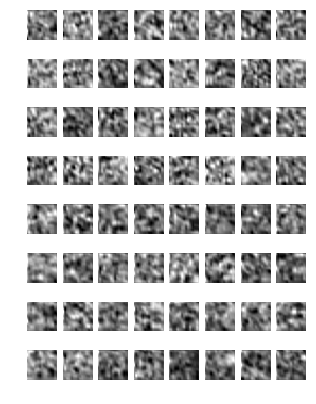

In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()

In [ ]:
0.2188